<a href="https://colab.research.google.com/github/ArthurFDLR/whisper-youtube/blob/main/whisper_youtube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Youtube Videos Transcription with OpenAI's Whisper**

Head over [here](https://github.com/ArthurFDLR/TO_COMPLETE) if you want to be up to date with the changes to this notebook and play with other alternatives.
For more information about **Whisper**, [visit the official repository](https://github.com/openai/whisper).

----

The interface is inspired by [Justin John's Notebooks available in his VQGAN-CLIP repository](https://github.com/justinjohn0306/VQGAN-CLIP).

In [1]:
#@markdown #**Check GPU type** 🕵️
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---

#@markdown V100 = Excellent (*Available only for Colab Pro users*)

#@markdown P100 = Very Good

#@markdown T4 = Good (*preferred*)

#@markdown K80 = Meh

#@markdown P4 = (*Not Recommended*) 

#@markdown ---

!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
#@markdown #**Install libraries** 🏗️
# @markdown This cell will take a little while because it has to download several libraries.

#@markdown ---

! pip install git+https://github.com/openai/whisper.git
! pip install pytube

import sys
import whisper
from pathlib import Path
import pytube
import subprocess
import torch
import shutil

# import io
# import os, time, glob
# import pickle
# import shutil
# import numpy as np
# from PIL import Image
# import unicodedata
# import re
# from tqdm.notebook import tqdm
from IPython.display import display, Markdown, YouTubeVideo
# from google.colab import files

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-2x_lfprj
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-2x_lfprj
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 163 kB 56.6 MB/s 
     |████████████████████████████████| 6.6 MB 32.9 MB/s 
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1175011 sha256=9fab0b3bf239c666f5d92c459e7d1e547045647d722df1cb0fd08e435b20dbea
  Stored in directory: /tmp/pip-ephem-wheel-cache-2zn47lqj/wheels/16/15/89/1c7bb31bd0006793a95549d04785121a8a36daad9158e1e43a
Successfully built whisper
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.4 MB/s 


Using device: cuda:0


In [3]:
#@markdown #**Optional:** Save images in Google Drive 💾
# @markdown Enter a Google Drive path and run this cell if you want to store the results inside Google Drive.

# Uncomment to copy generated images to drive, faster than downloading directly from colab in my experience.
from google.colab import drive
drive_mount_path = Path("/") / "content" / "drive"
drive.mount(str(drive_mount_path))
drive_mount_path /= "My Drive"
#@markdown ---
drive_path = "Colab Notebooks/Whisper Youtube" #@param {type:"string"}
#@markdown ---
#@markdown **Run this cell again if you change your Google Drive path.**

drive_whisper_path = drive_mount_path / Path(drive_path.lstrip("/"))
drive_whisper_path.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


In [4]:
#@markdown #**Model selection** 🎭

#@markdown As of the first public release, there are 4 pre-trained options to play with:

#@markdown |  Size  | Parameters | English-only model | Multilingual model |  
#@markdown |:------:|:----------:|:------------------:|:------------------:|
#@markdown |  tiny  |    39 M    |         ✓          |         ✓          |
#@markdown |  base  |    74 M    |         ✓          |         ✓          |
#@markdown | small  |   244 M    |         ✓          |         ✓          |
#@markdown | medium |   769 M    |         ✓          |         ✓          |
#@markdown | large  |   1550 M   |                    |         ✓          |

#@markdown ---
Model = 'large' #@param ['tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large']
#@markdown ---
#@markdown **Run this cell again if you change the model.**

whisper_model = whisper.load_model(Model)

if Model in whisper.available_models():
    display(Markdown(
        f"**{Model} model is selected.**"
    ))
else:
    display(Markdown(
        f"**{Model} model is no longer available.**<br /> Please select one of the following:<br /> - {'<br /> - '.join(whisper.available_models())}"
    ))

100%|█████████████████████████████████████| 2.87G/2.87G [01:19<00:00, 38.6MiB/s]


**large model is selected.**

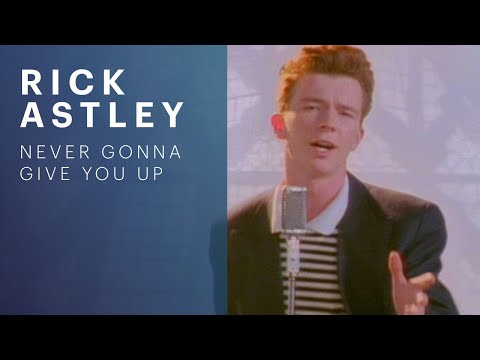

In [5]:
#@markdown #**Video selection** 🎭

#@markdown Enter the URL of the Youtube video you want to transcribe, wether you want to save the audio file in your Google Drive, and run the cell.

#@markdown ---
URL = "https://youtu.be/dQw4w9WgXcQ" #@param {type:"string"}
store_audio = True #@param {type:"boolean"}
#@markdown ---
#@markdown **Run this cell again if you change the video.**

video_yt = pytube.YouTube(URL)

try:
    video_yt.check_availability()
    display(
        YouTubeVideo(video_yt.video_id)
    )
except pytube.exceptions.VideoUnavailable:
    display(
        Markdown(f"**{URL} isn't available.**"),
    )


video_path_local = Path(".").resolve() / (video_yt.video_id+".wav")
video_yt.streams.filter(
    type="audio",
    mime_type="audio/mp4",
    abr="48kbps"
).first().download(
    output_path = video_path_local.parent,
    filename = video_path_local.name
)

result = subprocess.run(["ffmpeg", "-i", str(video_path_local.with_suffix(".mp4")), "-vn", "-acodec", "pcm_s16le", "-ar", "16000", "-ac", "1", str(video_path_local)])

if store_audio:
    shutil.copy(video_path_local, drive_whisper_path / video_path_local.name)

In [6]:
#@markdown #**Run the model** 🚀

#@markdown Run this cell to execute the transcription of the video. This can take a while and very based on the length of the video and the number of parameters of the model selected above.

#@markdown ---
Language = "English" #@param {type:"string"}
# save_transcription = True #@param {type:"boolean"}
Output_type = '.vtt' #@param ['.txt', '.vtt', '.srt']
#@markdown ---

language = None if not Language else Language

video_transcription = whisper_model.transcribe(
    str(video_path_local),
    verbose=True,
    language=language
)

writing_lut = {
    '.txt': whisper.utils.write_txt,
    '.vtt': whisper.utils.write_vtt,
    '.srt': whisper.utils.write_txt,
}

with open(video_path_local.with_suffix(Output_type), "w", encoding="utf-8") as f:
    writing_lut[Output_type](result["segments"], file=f)


/usr/local/lib/python3.7/dist-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


KeyboardInterrupt: ignored